In [284]:
# 1. Importar as Bibliotecas Necessárias
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import entropy
import math
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import completeness_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist

In [285]:
data = pd.read_csv("./dataset/dados_normalizados.csv")

X = data.iloc[:, :-1].values  # Excluindo a coluna 'Class' ou a última coluna
y_true = data['Class'].values

# 3. Normalizar os Dados
# scaler = StandardScaler()
# X = scaler.fit_transform(X) 
# print(X)


In [286]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [287]:
def calcular_coesao(X, labels):
    coesao_total = 0
    for label in np.unique(labels):
        if label == -1:  # Ignorar ruído, se houver
            continue
        cluster_points = X[labels == label]
        distancias = pdist(cluster_points)  # Calcula as distâncias entre todos os pares
        coesao_total += np.sum(distancias)
    return coesao_total

In [288]:
best = -1
best_i = 0
best_j = 0

for n_clusters in (2,3,4,5,6,7,8):
    for max_iter in (100,200,300,400,500):
        kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=0)
        kmeans.fit(X)

        score = kmeans.inertia_

        if(score > best):
            best_j = max_iter
            best_i = n_clusters

kmeans = KMeans(n_clusters=best_i, max_iter=best_j, random_state=0)
labels_pred_kmeans = kmeans.fit_predict(X)

print(f'Best n_clusters: {best_i}, Best max_iter: {best_j}')

print("\nCoesão: ", math.sqrt(kmeans.inertia_)/kmeans.n_clusters)

print("\nCoeficiente de silhueta médio: ", metrics.silhouette_score(X_pca,kmeans.labels_))

print("\nHomogeneidade : ",metrics.homogeneity_score(y_true,kmeans.labels_))

print("\nSeparação: ", pairwise_distances(kmeans.cluster_centers_).mean())

print("\nRand Score K-means: ",metrics.rand_score(y_true, kmeans.labels_))

print("\nCompletude: ", completeness_score(y_true, kmeans.labels_))

print("\nEntropia: ", entropy(np.bincount(kmeans.labels_)/len(kmeans.labels_)))



Best n_clusters: 8, Best max_iter: 500

Coesão:  11.274495338712436

Coeficiente de silhueta médio:  0.1732758463201497

Homogeneidade :  0.09789325018553963

Separação:  3.715561600968157

Rand Score K-means:  0.4533993993993994

Completude:  0.029598118977235

Entropia:  2.0203814977725005


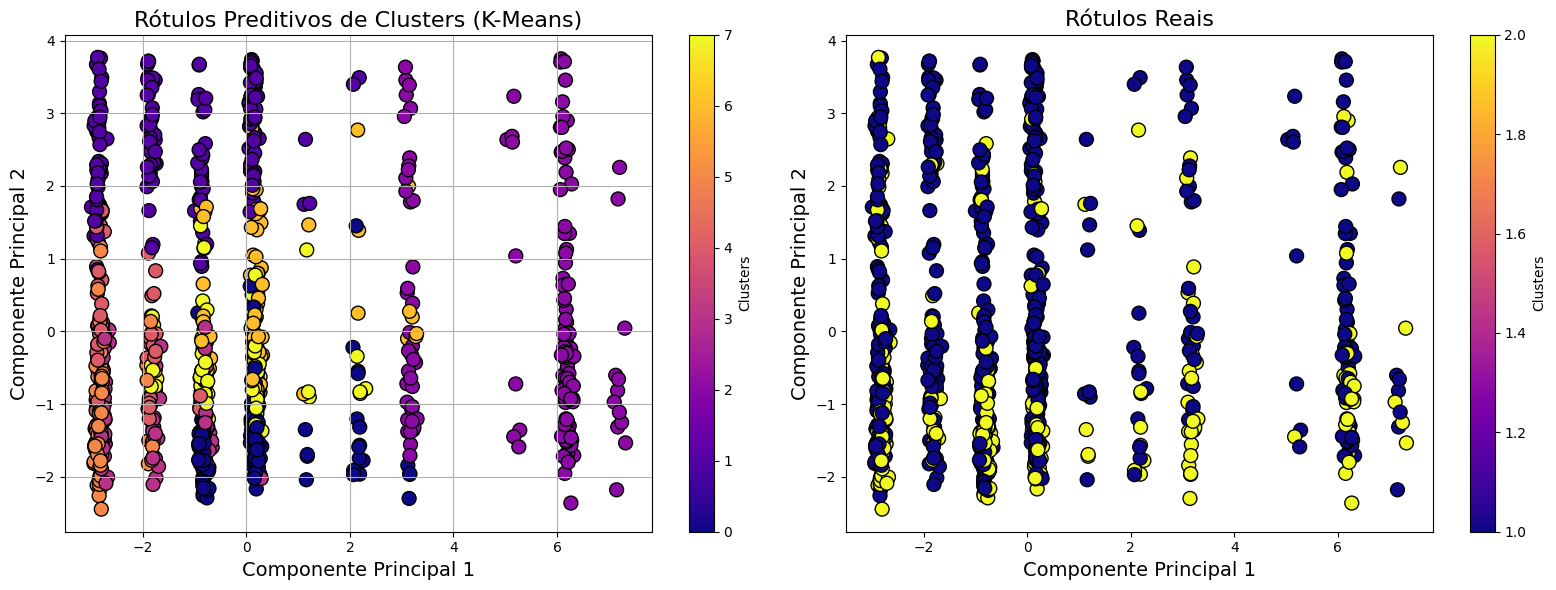

In [289]:
# Função para plotar os resultados
plt.figure(figsize=(16, 6))    
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='plasma', marker='o', edgecolor='k', s=100)
plt.title('Rótulos Reais', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=14)
plt.ylabel('Componente Principal 2', fontsize=14)
plt.colorbar(scatter, label='Clusters')

# Segundo Subplot: Rótulos Preditivos de Clusters
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pred_kmeans, cmap='plasma', marker='o', edgecolor='k', s=100)
plt.title('Rótulos Preditivos de Clusters (K-Means)', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=14)
plt.ylabel('Componente Principal 2', fontsize=14)
plt.colorbar(scatter, label='Clusters')
plt.grid(True)

# Salvar a Figura
plt.tight_layout()
plt.show()



In [330]:
best_score = -1

for eps in (2, 2.2, 2.4, 2.6, 2.8, 3, 3.2, 3.4):
    for min_s in (5, 10, 15, 20):
        dbscan = DBSCAN(eps=eps, min_samples=min_s)
        dbscan.fit(X)

        if len(set(dbscan.labels_)) > 1:  # Verifica se há mais de 1 cluster
            score = silhouette_score(X, dbscan.labels_)
            
            # Verificar se o score atual é melhor que o melhor score já encontrado
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_s
                

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels_pred_dbsacn = dbscan.fit_predict(X)

dist_matrix = pairwise_distances(X)

total_cohesion = 0
total_separation = 0
num_clusters = len(set(labels_pred_dbsacn)) - (1 if -1 in labels_pred_dbsacn else 0)
print(num_clusters)

for cluster_label in set(labels_pred_dbsacn):
    if cluster_label == -1:
        continue  # Ignora pontos de ruído
    
    # Índices dos pontos do cluster atual
    indices_current = np.where(labels_pred_dbsacn == cluster_label)[0]
    
    # Cálculo da coesão
    if len(indices_current) <= 1:
        continue  # Evita divisão por zero
    sum_dist_cohesion = np.sum(dist_matrix[np.ix_(indices_current, indices_current)])
    num_pairs_cohesion = len(indices_current) * (len(indices_current) - 1)
    cohesion = sum_dist_cohesion / num_pairs_cohesion
    total_cohesion += cohesion
    
    # Cálculo da separação mínima com outros clusters
    min_separation = np.inf
    for other_cluster_label in set(labels_pred_dbsacn):
        if other_cluster_label == cluster_label or other_cluster_label == -1:
            continue
        indices_other = np.where(labels_pred_dbsacn == other_cluster_label)[0]
        separation = np.min(dist_matrix[np.ix_(indices_current, indices_other)])
        min_separation = min(min_separation, separation)
    
    total_separation += min_separation



print(f'Best EPS: {best_eps:.4f}, Best Min Samples: {best_min_samples}')

if num_clusters > 0:
    average_cohesion = total_cohesion / num_clusters
    average_separation = total_separation / num_clusters
    print(f"\nCoesão Média dos Clusters: {average_cohesion:.4f}")
    print(f"\nSeparação Média dos Clusters: {average_separation:.4f}")
else:
    print("\nNenhum cluster válido encontrado.")

print("\nCoeficiente de Silhueta: ", metrics.silhouette_score(X_pca, dbscan.labels_))

print("\nHomogeneidade : ",metrics.homogeneity_score(y_true,dbscan.labels_))

print("\nRand Score: ",metrics.rand_score(y_true, dbscan.labels_))

print("\nCompletude: ", metrics.completeness_score(y_true, dbscan.labels_))

print("\nEntropia: ", entropy(np.bincount(dbscan.labels_[dbscan.labels_ != -1])/len(dbscan.labels_)))



2
Best EPS: 3.2000, Best Min Samples: 20

Coesão Média dos Clusters: 4.4780

Separação Média dos Clusters: 3.0191

Coeficiente de Silhueta:  0.49747285798873386

Homogeneidade :  0.006783663714708433

Rand Score:  0.5454034034034034

Completude:  0.008370881503702932

Entropia:  0.3066188750026747


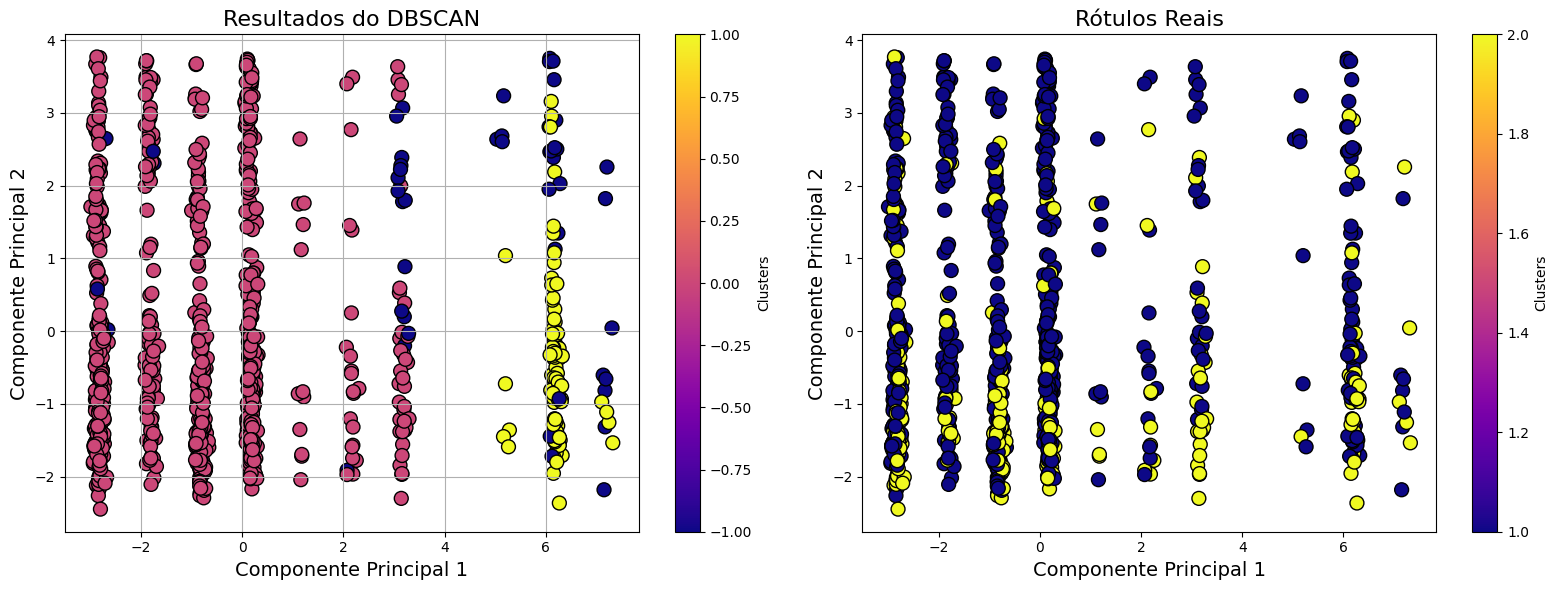

In [326]:
plt.figure(figsize=(16, 6))    
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='plasma', marker='o', edgecolor='k', s=100)
plt.title('Rótulos Reais', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=14)
plt.ylabel('Componente Principal 2', fontsize=14)
plt.colorbar(scatter, label='Clusters')

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pred_dbsacn, cmap='plasma', marker='o', edgecolor='k', s=100)
plt.title('Resultados do DBSCAN', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=14)
plt.ylabel('Componente Principal 2', fontsize=14)
plt.colorbar(scatter, label='Clusters')
plt.grid(True)
plt.tight_layout()
plt.show()

In [292]:
best_score = -1

for n_clusters in (2,3,4,5,6,7,8):
    for linkage in ('ward', 'complete', 'average', 'single'):
        agnes = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        agnes.fit(X)

        if len(set(agnes.labels_)) > 1:
            score = silhouette_score(X, agnes.labels_)

            if score > best_score:
                best_score = score
                best_linkage = linkage
                best_ncluster = n_clusters




agnes = AgglomerativeClustering(n_clusters=best_ncluster, linkage=best_linkage)
labels_pred_agnes = agnes.fit_predict(X)

dist_matrix = pairwise_distances(X)

total_cohesion = 0
num_clusters = len(set(labels_pred_agnes))

for cluster_label in set(labels_pred_agnes):

    indices_current = np.where(labels_pred_agnes == cluster_label)[0]
    

    if len(indices_current) <= 1:
        continue  
    sum_dist_cohesion = np.sum(dist_matrix[np.ix_(indices_current, indices_current)])
    num_pairs_cohesion = len(indices_current) * (len(indices_current) - 1)
    cohesion = sum_dist_cohesion / num_pairs_cohesion
    total_cohesion += cohesion
    

    min_separation = np.inf
    for other_cluster_label in set(labels_pred_agnes):
        if other_cluster_label == cluster_label:
            continue
        indices_other = np.where(labels_pred_agnes == other_cluster_label)[0]
        separation = np.min(dist_matrix[np.ix_(indices_current, indices_other)])
        min_separation = min(min_separation, separation)
    
    total_separation += min_separation

print(f'Best linkage: {best_linkage}, Best n_clusters: {best_ncluster}')

if num_clusters > 0:
    average_cohesion = total_cohesion / num_clusters
    average_separation = total_separation / num_clusters
    print(f"\nCoesão Média dos Clusters: {average_cohesion:.4f}")
    print(f"\nSeparação Média dos Clusters: {average_separation:.4f}")
else:
    print("\nNenhum cluster encontrado.")

print("\nCoeficiente de Silhueta médio: ", metrics.silhouette_score(X_pca, agnes.labels_))

print("\nHomogeneidade : ",metrics.homogeneity_score(y_true,agnes.labels_))

print("\nRand Score: ",metrics.rand_score(y_true, agnes.labels_))

print("\nCompletude: ", completeness_score(y_true, agnes.labels_))

print("\nEntropia: ", entropy(np.bincount(agnes.labels_)/len(agnes.labels_)))


Best linkage: complete, Best n_clusters: 2

Coesão Média dos Clusters: 4.8965

Separação Média dos Clusters: 4.3363

Coeficiente de Silhueta médio:  0.5879561412233888

Homogeneidade :  0.00026051115955235175

Rand Score:  0.5457537537537538

Completude:  0.0004039825345637517

Entropia:  0.3939204149736461


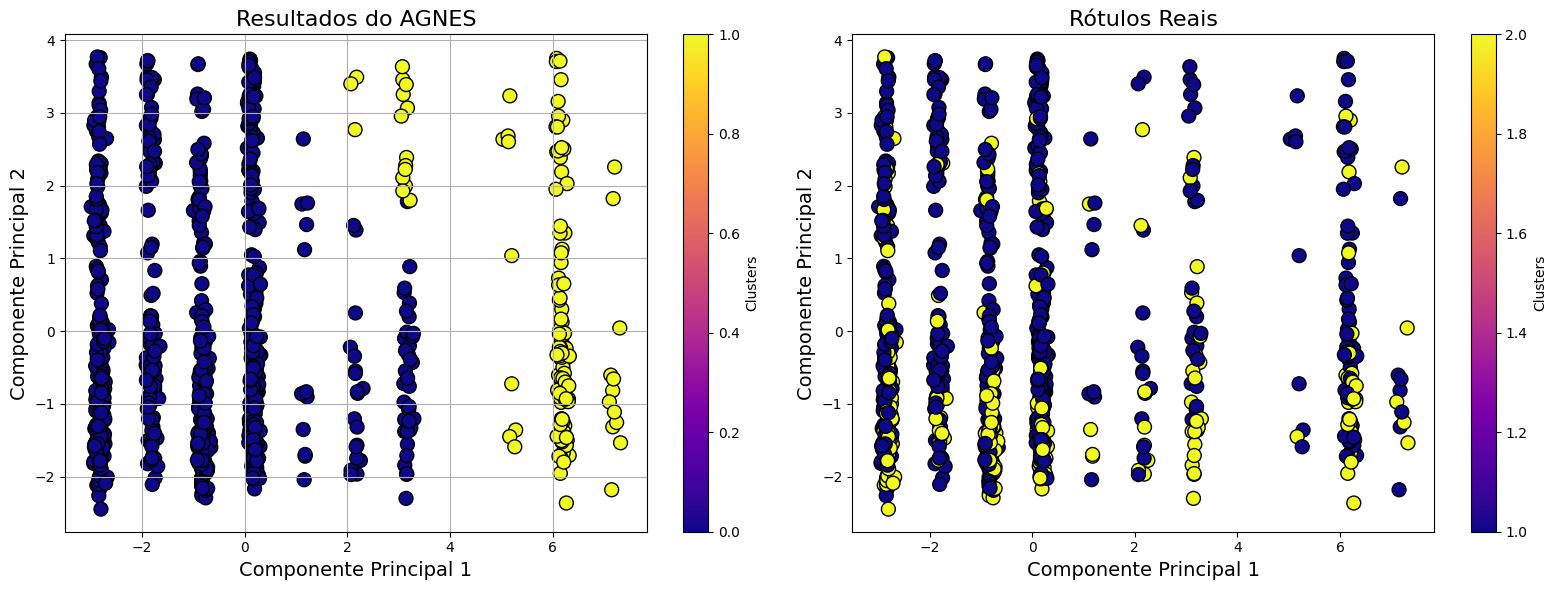

In [293]:
plt.figure(figsize=(16, 6))    
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='plasma', marker='o', edgecolor='k', s=100)
plt.title('Rótulos Reais', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=14)
plt.ylabel('Componente Principal 2', fontsize=14)
plt.colorbar(scatter, label='Clusters')

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pred_agnes, cmap='plasma', marker='o', edgecolor='k', s=100)
plt.title('Resultados do AGNES', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=14)
plt.ylabel('Componente Principal 2', fontsize=14)
plt.colorbar(scatter, label='Clusters')
plt.grid(True)
plt.tight_layout()
plt.show()